In [1]:
import numpy as np 
import pandas as pd 

import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from sklearn.model_selection import train_test_split

#import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [2]:
# Import files from the competition directories

path = '/kaggle/input/happy-whale-and-dolphin/'
os.listdir(path)

['sample_submission.csv', 'train_images', 'train.csv', 'test_images']

In [3]:
# load the train data as well as the sample submission format

train_path = os.path.join(path, 'train_images')
test_path = os.path.join(path, 'test_images')
train_data = pd.read_csv(path + 'train.csv')
sample_sub = pd.read_csv(path + 'sample_submission.csv')

In [4]:
# Preview train data
train_data

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392
...,...,...,...
51028,fff639a7a78b3f.jpg,beluga,5ac053677ed1
51029,fff8b32daff17e.jpg,cuviers_beaked_whale,1184686361b3
51030,fff94675cc1aef.jpg,blue_whale,5401612696b9
51031,fffbc5dd642d8c.jpg,beluga,4000b3d7c24e


In [5]:
# Preview sample submission 
sample_sub

,image,predictions
0,000110707af0ba.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
1,0006287ec424cb.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
2,000809ecb2ccad.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
3,00098d1376dab2.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
4,000b8d89c738bd.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
...,...,...
27951,fff6ff1989b5cd.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
27952,fff8fd932b42cb.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
27953,fff96371332c16.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
27954,fffc1c4d3eabc7.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...


### 1. Description of the Problem and Data

For this project, I've chosen to enter the "Happywhale - Whale and Dolphin Identification" Kaggle competition. This competition has the stated purpose of creating an algorithm to aid the Happywhale platform - a research collaboration and citizen science application - in the identification of whale and dolphin individuals from photographs (mainly of dorsal fins during surface breaches) taken around the world. 

The training database consists of 51,033 such images, labeled with the species and individual, which we will use to create a classifier that will attempt to classify the species of the animal in each photograph.

In the course of this analysis, I will expand on the binary classifier Convolutional Neural Network that we learned earlier on in the course and attempt to apply it to this more difficult task of multi-class classification, based on species. We will apply two sets of conditions to each prediction: 

- Model type (basic CNN architecture vs. Inceptionv3)
- Dataset type (full dataset vs. reduced/standardized dataset)

### 2. Exploratory Data Analysis

In [6]:
train_data.head()

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392


In [7]:
train_data.isnull().sum()

image            0
species          0
individual_id    0
dtype: int64

No null values - we have a nicely cleaned dataset. 

In [8]:
train_data.describe()

,image,species,individual_id
count,51033,51033,51033
unique,51033,30,15587
top,00021adfb725ed.jpg,bottlenose_dolphin,37c7aba965a5
freq,1,9664,400


Here we see a snapshot of our training data directory. We wee that our data is made up of an image filepath, corresponding to an image contained in the accompanying train folder, as well as data on the species of the whale/dolphin in question, and a code unique to each individual in the database. 

What's the breakdown of our "species" feature?

In [9]:
print('Number of unique species: ', train_data['species'].nunique())
species = list(train_data['species'].unique())
species.sort()
print(species)

Number of unique species:  30
['beluga', 'blue_whale', 'bottlenose_dolphin', 'bottlenose_dolpin', 'brydes_whale', 'commersons_dolphin', 'common_dolphin', 'cuviers_beaked_whale', 'dusky_dolphin', 'false_killer_whale', 'fin_whale', 'frasiers_dolphin', 'globis', 'gray_whale', 'humpback_whale', 'kiler_whale', 'killer_whale', 'long_finned_pilot_whale', 'melon_headed_whale', 'minke_whale', 'pantropic_spotted_dolphin', 'pilot_whale', 'pygmy_killer_whale', 'rough_toothed_dolphin', 'sei_whale', 'short_finned_pilot_whale', 'southern_right_whale', 'spinner_dolphin', 'spotted_dolphin', 'white_sided_dolphin']


We can see a few duplicates due to spelling errors, as well as some known duplicates, or merged species names. We'll go ahead and standardize those across the data. 

In [10]:
train_data['species'].replace({"globis": "short_finned_pilot_whale",
                               "pilot_whale": "short_finned_pilot_whale",
                               "kiler_whale": "killer_whale",
                               "bottlenose_dolpin": "bottlenose_dolphin"}, 
                              inplace=True)

In [11]:
print('Number of unique species: ', train_data['species'].nunique())
list(train_data['species'].unique())

Number of unique species:  26


['melon_headed_whale',
 'humpback_whale',
 'false_killer_whale',
 'bottlenose_dolphin',
 'beluga',
 'minke_whale',
 'fin_whale',
 'blue_whale',
 'gray_whale',
 'southern_right_whale',
 'common_dolphin',
 'killer_whale',
 'short_finned_pilot_whale',
 'dusky_dolphin',
 'long_finned_pilot_whale',
 'sei_whale',
 'spinner_dolphin',
 'cuviers_beaked_whale',
 'spotted_dolphin',
 'brydes_whale',
 'commersons_dolphin',
 'white_sided_dolphin',
 'rough_toothed_dolphin',
 'pantropic_spotted_dolphin',
 'pygmy_killer_whale',
 'frasiers_dolphin']

In [12]:
train_data['species'].value_counts()

bottlenose_dolphin           10781
beluga                        7443
humpback_whale                7392
blue_whale                    4830
false_killer_whale            3326
dusky_dolphin                 3139
killer_whale                  2455
spinner_dolphin               1700
melon_headed_whale            1689
minke_whale                   1608
fin_whale                     1324
gray_whale                    1123
southern_right_whale           866
short_finned_pilot_whale       745
spotted_dolphin                490
sei_whale                      428
common_dolphin                 347
cuviers_beaked_whale           341
long_finned_pilot_whale        238
white_sided_dolphin            229
brydes_whale                   154
pantropic_spotted_dolphin      145
commersons_dolphin              90
pygmy_killer_whale              76
rough_toothed_dolphin           60
frasiers_dolphin                14
Name: species, dtype: int64

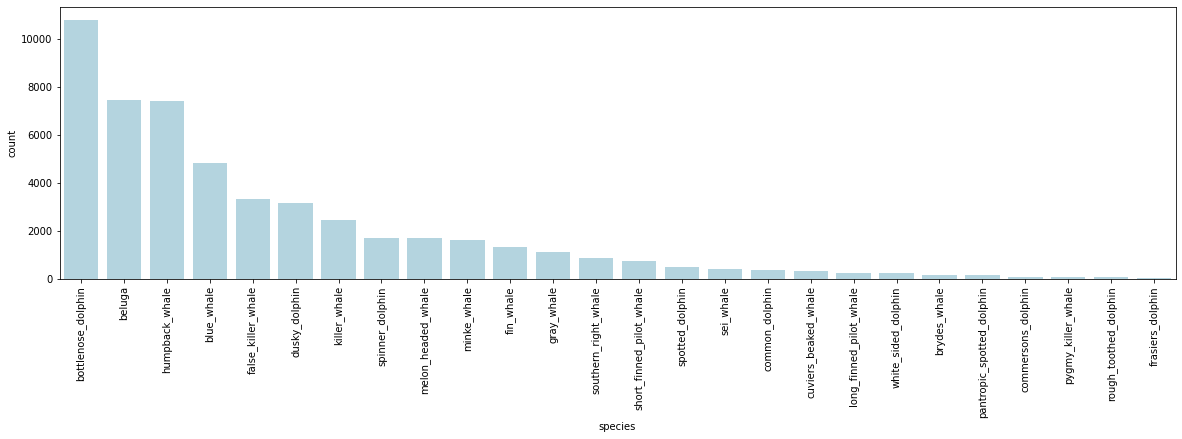

In [13]:
fig = plt.figure(figsize = (20,5))
sns.countplot(x = train_data['species'], 
              order = train_data['species'].value_counts().index, 
              color = 'lightblue')
plt.xticks(rotation = 90)
plt.show()

We can see here that there is a considerable range in the number of species present in this dataset - ranging from almost 11,000 bottlenose dolphin samples to a paltry 14 in the case of the frasier's dolphin. 

Next, we'll examine our individual_id feature. 

In [14]:
individual_freq = train_data['individual_id'].value_counts().value_counts()
individual_freq

1      9258
2      3091
3       773
4       741
5       374
       ... 
89        1
93        1
94        1
98        1
400       1
Name: individual_id, Length: 108, dtype: int64

In [15]:
train_data

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392
...,...,...,...
51028,fff639a7a78b3f.jpg,beluga,5ac053677ed1
51029,fff8b32daff17e.jpg,cuviers_beaked_whale,1184686361b3
51030,fff94675cc1aef.jpg,blue_whale,5401612696b9
51031,fffbc5dd642d8c.jpg,beluga,4000b3d7c24e


In [16]:
print("Number of unique individuals:", 
      train_data['individual_id'].unique().size, '\n')

ind_counts = train_data['individual_id'].value_counts()

print("Number of individuals with more than 100 images:", 
      len(ind_counts[ind_counts>100]), '\n')

print("Number of individuals with only 1 image:", 
      len(ind_counts[ind_counts==1]), '\n')

Number of unique individuals: 15587 

Number of individuals with more than 100 images: 27 

Number of individuals with only 1 image: 9258 



In [17]:
ind_counts.describe()

count    15587.000000
mean         3.274075
std          9.242430
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        400.000000
Name: individual_id, dtype: float64

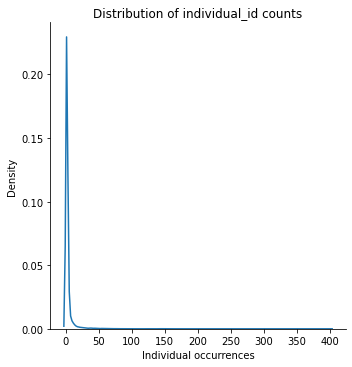

In [18]:
sns.displot(x = ind_counts, kind = 'kde')
plt.title('Distribution of individual_id counts')
plt.xlabel('Individual occurrences')
plt.show()

We can see that the distribution of individual occurrences is *extremely* right-skewed. Almost 2/3 of the set of unique inidividuals represented in the dataset occur only once, and only 27 of the more than 15,000 individuals represented are observed more than 100 times. 

Next, let's take a brief look at a few of our sample images. 

In [19]:
# Display images in a 4x4 grid
nrows = 4
ncols = 4

# Set a starting index to use when iterating through images
pic_index = 0

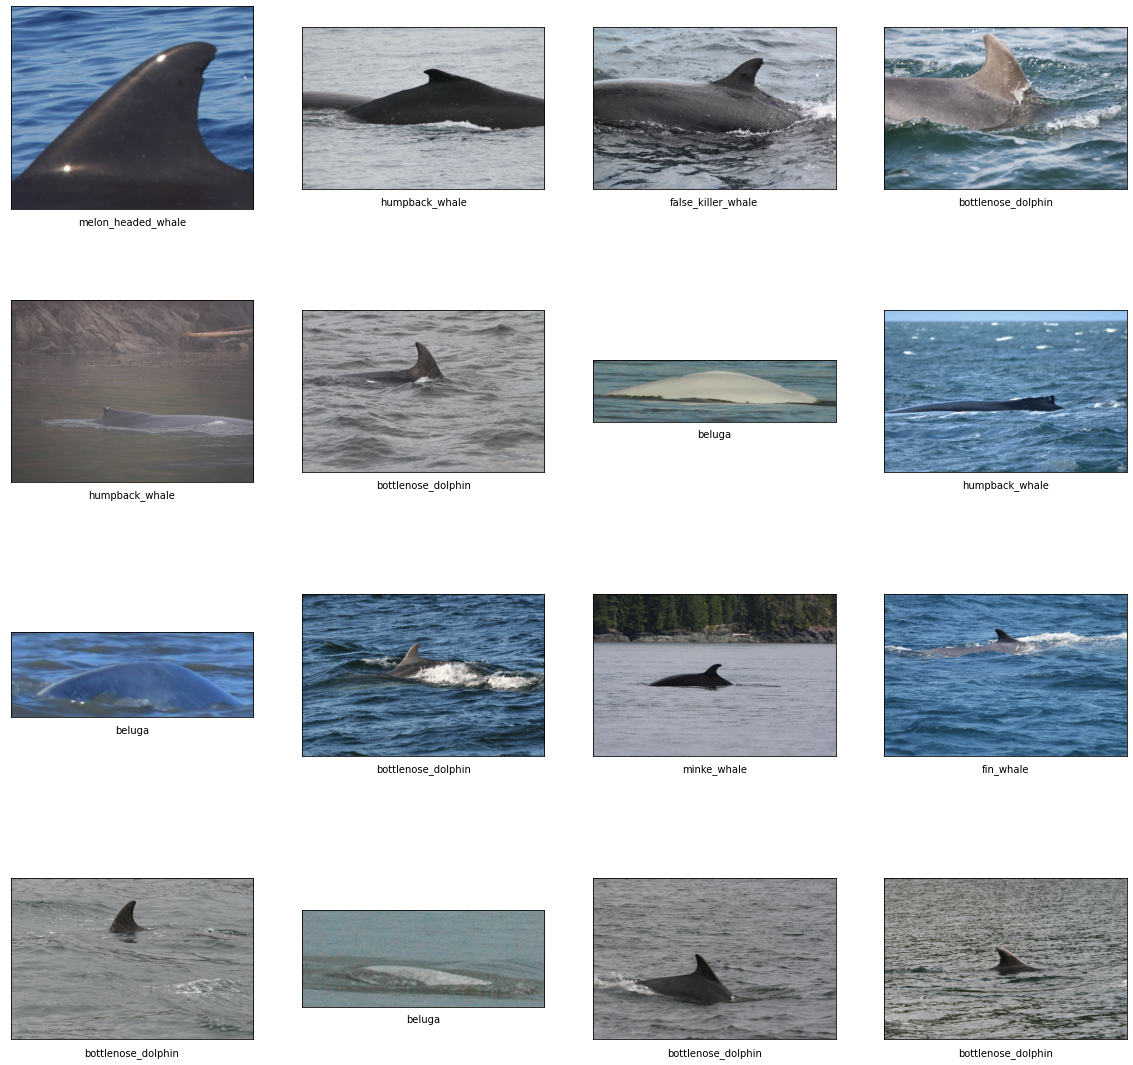

In [20]:
# Set matplotlib figure
fix, axs = plt.subplots(nrows,  ncols, figsize = (20, 20))

# load a new set of images every time this cell runs
pic_index += nrows*ncols
next_pics = train_data[pic_index-nrows*ncols : pic_index].reset_index()
#print(next_pics)
for i, axis in enumerate(axs.flat):
    fname = os.path.join(train_path, next_pics['image'][i])
    spec = next_pics['species'][i]
    img = mpimg.imread(fname)
    axis.imshow(img)
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(spec)

plt.show()

We can see as we cycle through these images present in our training data contain a great deal of variety in terms of their orientation, scale, background, resolution, etc. Some images seem to have text in the foreground - perhaps sourced from some sort of curated collection as reference material. Still others are rendered in what I assume to be some sort of infrared color scale. We see other images in which more than one individual is present within the frame. We'll have to keep this variety in mind, especially when we're trying to discern later on whether or not to augment our images in our preprocessing step. 

Per our stated purpose, we'll drop the individual_id feature, since we'll be focusing on the species classification for this project. 

In [21]:
train_data = train_data.drop(['individual_id'], axis = 1)
train_data

,image,species
0,00021adfb725ed.jpg,melon_headed_whale
1,000562241d384d.jpg,humpback_whale
2,0007c33415ce37.jpg,false_killer_whale
3,0007d9bca26a99.jpg,bottlenose_dolphin
4,00087baf5cef7a.jpg,humpback_whale
...,...,...
51028,fff639a7a78b3f.jpg,beluga
51029,fff8b32daff17e.jpg,cuviers_beaked_whale
51030,fff94675cc1aef.jpg,blue_whale
51031,fffbc5dd642d8c.jpg,beluga


Among our species feature, as observed above, we have a huge variety in the number of observations. In the course of this analysis, I propose to examine the relative effectiveness of Convolutional Neural Networks (one with a basic architecture, and another pre-trained) in classifying a multivariate feature. 

We'll test each model against two datasets - one in which we haven't modified the classes at all, and one in which we've kept only the classes that have more than 1000 observations, and standardized the number of observations in each remaining class. 

In [22]:
species_counts = train_data['species'].value_counts()
species_counts

bottlenose_dolphin           10781
beluga                        7443
humpback_whale                7392
blue_whale                    4830
false_killer_whale            3326
dusky_dolphin                 3139
killer_whale                  2455
spinner_dolphin               1700
melon_headed_whale            1689
minke_whale                   1608
fin_whale                     1324
gray_whale                    1123
southern_right_whale           866
short_finned_pilot_whale       745
spotted_dolphin                490
sei_whale                      428
common_dolphin                 347
cuviers_beaked_whale           341
long_finned_pilot_whale        238
white_sided_dolphin            229
brydes_whale                   154
pantropic_spotted_dolphin      145
commersons_dolphin              90
pygmy_killer_whale              76
rough_toothed_dolphin           60
frasiers_dolphin                14
Name: species, dtype: int64

In [23]:
# Eliminate rare species from our reduced dataset
rare_species = species_counts[species_counts<1000].index
train_data_red = train_data.copy()
for spec in rare_species: 
    train_data_red = train_data_red[train_data_red['species'] != spec]
    
train_data_red['species'].value_counts()

bottlenose_dolphin    10781
beluga                 7443
humpback_whale         7392
blue_whale             4830
false_killer_whale     3326
dusky_dolphin          3139
killer_whale           2455
spinner_dolphin        1700
melon_headed_whale     1689
minke_whale            1608
fin_whale              1324
gray_whale             1123
Name: species, dtype: int64

In [24]:
# Sample a random collection of 1000 of each class

train_data_red = train_data_red.groupby('species').sample(1000)
train_data_red = train_data_red.sample(frac=1)
train_data_red = train_data_red.reset_index(drop=True)
train_data_red['species'].value_counts()

false_killer_whale    1000
humpback_whale        1000
dusky_dolphin         1000
beluga                1000
bottlenose_dolphin    1000
melon_headed_whale    1000
blue_whale            1000
spinner_dolphin       1000
minke_whale           1000
fin_whale             1000
gray_whale            1000
killer_whale          1000
Name: species, dtype: int64

Great - we have a reduced dataset of 12,000 images spread out evenly across 12 classes. For comparison, we'll produce a similar dataset of 12,000 images randomly sampled from the original dataset. 

In [25]:
train_data_ctrl = train_data.sample(
    12000, 
    random_state = 12
)
train_data_ctrl = train_data_ctrl.reset_index(drop = True)
train_data_ctrl['species'].value_counts()

bottlenose_dolphin           2501
humpback_whale               1810
beluga                       1698
blue_whale                   1149
false_killer_whale            817
dusky_dolphin                 734
killer_whale                  563
spinner_dolphin               415
melon_headed_whale            402
minke_whale                   361
fin_whale                     315
gray_whale                    265
southern_right_whale          192
short_finned_pilot_whale      172
spotted_dolphin               103
sei_whale                     101
common_dolphin                 97
cuviers_beaked_whale           69
long_finned_pilot_whale        61
white_sided_dolphin            51
pantropic_spotted_dolphin      38
brydes_whale                   30
commersons_dolphin             24
pygmy_killer_whale             19
rough_toothed_dolphin          12
frasiers_dolphin                1
Name: species, dtype: int64

Last of all, we want to ascertain the sizes of the images in our dataset, so as to determine the best way to resize the inputs. 

In [26]:
largest_size = (0,0,0)
smallest_size = (1000,1000,0)

for i in range(100):
    img = mpimg.imread(os.path.join(train_path, train_data_ctrl['image'][i]))
    size = img.shape
    if size[0]*size[1] > largest_size[0]*largest_size[1]:
        largest_size = size
    if size[0]*size[1] < smallest_size[0]*smallest_size[1]:
        smallest_size = size
    
print('Smallest image size: ', smallest_size)
print('Largest image size: ', largest_size)

Smallest image size:  (296, 270, 3)
Largest image size:  (2409, 3599, 3)


We have a considerable range in image resolutions here! To be safe, we'll standardize our input image size to 96x96x3. 

### 3. Model Architecture

#### Data Preprocessing

We will implement the following preprocessing steps:

**Normalization:** we will normalize the pizel data of the images prior to training by dividing each value by 255. 

**Batch sizes:** following our work on stochastic gradients, we'll use a batch size of 100 during model training. 

In the interest of reducing computation times, we have chosen not to implement data augmentation. 

In [27]:
# Set global variables
batch_size = 100
random_state = 12
n_epochs = 5
n_species_ctrl = train_data_ctrl['species'].nunique()
n_species_red = train_data_red['species'].nunique()
n_pixels = 96

In [28]:
# Rescale all images by 1/255
datagen = ImageDataGenerator(rescale = 1/255, 
                             validation_split = 0.2)

In [29]:
# Flow training images 
train_generator_ctrl = datagen.flow_from_dataframe(
    dataframe = train_data_ctrl, 
    x_col = 'image', 
    y_col = 'species', 
    directory = train_path, 
    batch_size = batch_size, 
    class_mode = 'categorical', 
    target_size = (n_pixels, n_pixels), 
    subset = 'training', 
    seed = random_state
)

# Flow validation images
val_generator_ctrl = datagen.flow_from_dataframe(
    dataframe = train_data_ctrl, 
    x_col = 'image', 
    y_col = 'species', 
    directory = train_path, 
    batch_size = batch_size, 
    class_mode = 'categorical', 
    target_size = (n_pixels, n_pixels), 
    subset = 'validation', 
    seed = random_state
)

Found 9600 validated image filenames belonging to 26 classes.
Found 2400 validated image filenames belonging to 26 classes.


In [30]:
# Flow reduced training images
train_generator_red = datagen.flow_from_dataframe(
    dataframe = train_data_red, 
    x_col = 'image', 
    y_col = 'species', 
    directory = train_path, 
    batch_size = batch_size, 
    class_mode = 'categorical', 
    target_size = (n_pixels, n_pixels), 
    subset = 'training', 
    seed = random_state
)

# Flow reduced validation images
val_generator_red = datagen.flow_from_dataframe(
    dataframe = train_data_red, 
    x_col = 'image', 
    y_col = 'species', 
    directory = train_path, 
    batch_size = batch_size, 
    class_mode = 'categorical', 
    target_size = (n_pixels, n_pixels), 
    subset = 'validation', 
    seed = random_state
)

Found 9600 validated image filenames belonging to 12 classes.
Found 2400 validated image filenames belonging to 12 classes.


In [31]:
# An auxiliary function to display diagnostic plots

def diagnostic_plots(history):
  # A helper function to display the accuracy, loss and AUC for each model that we train. 
  # Import: a history object returned from tf.keras.Model.fit()
  # Displays a plot of accuracy, loss, and auc for training and validation data

  fig, axs = plt.subplots(nrows = 1, ncols = 2, sharey = True, figsize = (20,4))

  n_epochs = len(history.history['acc'])

  train_acc = history.history['acc']
  val_acc = history.history['val_acc']
  axs[0].plot(range(n_epochs), train_acc)
  axs[0].plot(range(n_epochs), val_acc)
  axs[0].set_title('Accuracy')
  axs[0].legend(['train', 'validate'], loc = 'upper left') 

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  axs[1].plot(range(n_epochs), train_loss)
  axs[1].plot(range(n_epochs), val_loss)
  axs[1].set_title('Loss')
  axs[1].legend(['train', 'validate'], loc = 'upper left')

#### Initial Model (basic CNN architecture)

For this project, we'll be using the Keras API to train and test CNN's on our image data. 

Our initial model architecture will consist of one convolutional layer, followed by a max-pooling layers, followed by a single dense layer and dropout layer before the output. In summary: 

1. Input (resized to 
2. Conv2D (ReLu activation)
3. Max Pool
4. Flatten
5. Dense (ReLu activation)
6. Dropout (0.2)
7. Output (SoftMax activation)

**Optimization:** we will use the AdaGrad optimization algorithm, since it automatically rescales the gradients of each parameter for us. 
 

In [35]:
# Building out our initial CNN

img_input = layers.Input(shape=(n_pixels, n_pixels, 3))

x = layers.Conv2D(32, 3, activation = 'relu')(img_input)
x = layers.MaxPooling2D(2)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)

output = layers.Dense(n_species_ctrl, activation = 'softmax')(x)

model_ctrl = Model(img_input, output)

# Compile the model
model_ctrl.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adagrad(), 
    metrics = ['acc']
)

model_ctrl.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 70688)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               9048192   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 26)                3354

Epoch 1/5
96/96 [==============================] - 881s 9s/step - loss: 2.4452 - acc: 0.2747 - val_loss: 2.2241 - val_acc: 0.3542
Epoch 2/5
96/96 [==============================] - 810s 8s/step - loss: 2.2465 - acc: 0.3439 - val_loss: 2.1470 - val_acc: 0.3496
Epoch 3/5
96/96 [==============================] - 760s 8s/step - loss: 2.1517 - acc: 0.3793 - val_loss: 2.0574 - val_acc: 0.4100
Epoch 4/5
96/96 [==============================] - 767s 8s/step - loss: 2.0977 - acc: 0.3928 - val_loss: 1.9928 - val_acc: 0.4367
Epoch 5/5
96/96 [==============================] - 755s 8s/step - loss: 2.0455 - acc: 0.4100 - val_loss: 1.9524 - val_acc: 0.4487


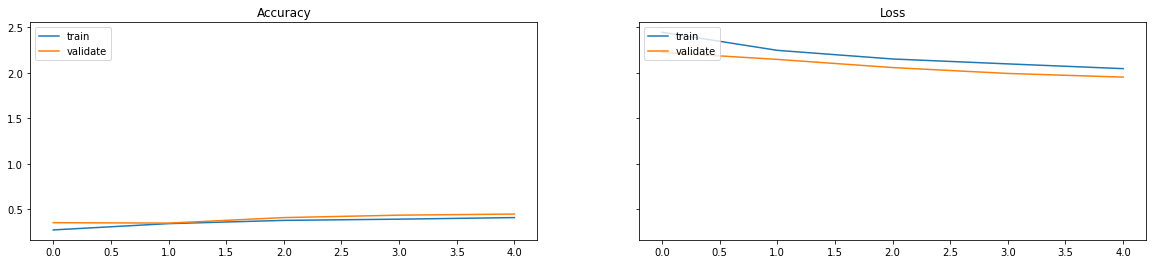

In [36]:
history_ctrl = model_ctrl.fit(
    train_generator_ctrl, 
    epochs = n_epochs, 
    validation_data = val_generator_ctrl
)
diagnostic_plots(history_ctrl)

Next, we'll use the same model architecture and initial parameters, and examine the model performance with the standardized dataset. 

In [37]:
img_input = layers.Input(shape=(n_pixels, n_pixels, 3))

x = layers.Conv2D(32, 3, activation = 'relu')(img_input)
x = layers.MaxPooling2D(2)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)

output = layers.Dense(n_species_red, activation = 'softmax')(x)

model_red = Model(img_input, output)

# Compile the model
model_red.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adagrad(), 
    metrics = ['acc']
)

model_red.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 70688)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               9048192   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 12)                1548

Epoch 1/5
96/96 [==============================] - 974s 10s/step - loss: 2.3738 - acc: 0.1924 - val_loss: 2.2374 - val_acc: 0.3096
Epoch 2/5
96/96 [==============================] - 955s 10s/step - loss: 2.1698 - acc: 0.2802 - val_loss: 2.0609 - val_acc: 0.3354
Epoch 3/5
96/96 [==============================] - 872s 9s/step - loss: 2.0328 - acc: 0.3178 - val_loss: 1.9600 - val_acc: 0.3938
Epoch 4/5
96/96 [==============================] - 780s 8s/step - loss: 1.9574 - acc: 0.3354 - val_loss: 1.8840 - val_acc: 0.3913
Epoch 5/5
96/96 [==============================] - 770s 8s/step - loss: 1.8953 - acc: 0.3595 - val_loss: 1.8338 - val_acc: 0.4171


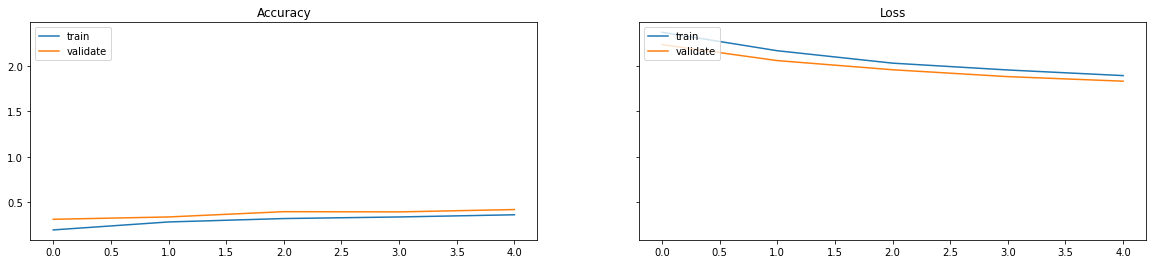

In [38]:
history_red = model_red.fit(
    train_generator_red, 
    epochs = n_epochs, 
    validation_data = val_generator_red
)
diagnostic_plots(history_red)

Next, we'll apply a pre-trained model the the same datasets under the same conditions to see how it performs. For this analysis, we'll be using the InceptionV3 architecture. This model balances the effective classification accuracy with a reasonable size (92MB), which will help us given our limited access to computing resources. 

In [39]:
model_base = InceptionV3(
    input_shape = (n_pixels, n_pixels, 3), 
    include_top = False, 
    weights = 'imagenet'
)

# Set the base model weights as immutable 
for layer in model_base.layers:
    layer.trainable = False

In [40]:
last_layer = model_base.get_layer('mixed7')
last_output = last_layer.output
last_output

<KerasTensor: shape=(None, 4, 4, 768) dtype=float32 (created by layer 'mixed7')>

In [41]:
x = layers.Flatten()(last_output)
x = layers.Dense(128, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(n_species_ctrl, activation = 'softmax')(x)

model_V3_ctrl = Model(model_base.input, output)

model_V3_ctrl.compile(
    loss = 'categorical_crossentropy', 
    optimizer = Adagrad(), 
    metrics = ['acc']
)

model_V3_ctrl.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 47, 47, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 47, 47, 32)   96          conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 47, 47, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

Epoch 1/5
96/96 [==============================] - 942s 10s/step - loss: 1.9977 - acc: 0.4554 - val_loss: 1.5123 - val_acc: 0.5858
Epoch 2/5
96/96 [==============================] - 892s 9s/step - loss: 1.4816 - acc: 0.5871 - val_loss: 1.2958 - val_acc: 0.6354
Epoch 3/5
96/96 [==============================] - 808s 8s/step - loss: 1.3062 - acc: 0.6283 - val_loss: 1.1745 - val_acc: 0.6700
Epoch 4/5
96/96 [==============================] - 759s 8s/step - loss: 1.2071 - acc: 0.6546 - val_loss: 1.1101 - val_acc: 0.6833
Epoch 5/5
96/96 [==============================] - 752s 8s/step - loss: 1.1219 - acc: 0.6785 - val_loss: 1.0481 - val_acc: 0.7042


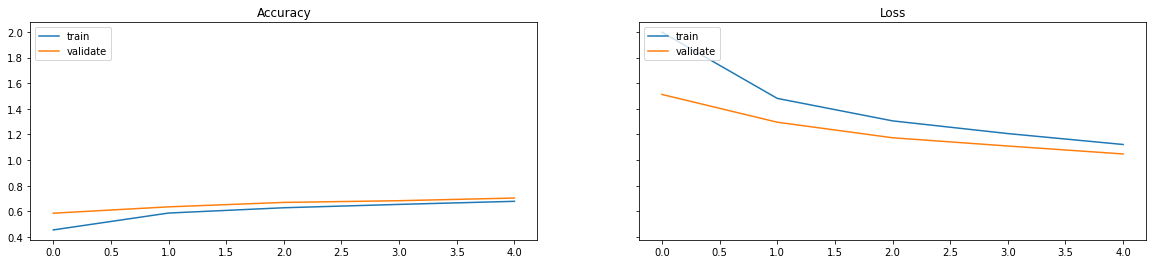

In [42]:
history_V3_ctrl = model_V3_ctrl.fit(
    train_generator_ctrl, 
    epochs = n_epochs, 
    validation_data = val_generator_ctrl
)

diagnostic_plots(history_V3_ctrl)

And finally, we'll apply the same InceptionV3 architecture to our reduced and standardized dataset. 

In [43]:
output = layers.Dense(n_species_red, activation = 'softmax')(x)

model_V3_red = Model(model_base.input, output)

model_V3_red.compile(
    loss = 'categorical_crossentropy', 
    optimizer = Adagrad(), 
    metrics = ['acc']
)

#model_V3_red.summary()

Epoch 1/5
96/96 [==============================] - 974s 10s/step - loss: 1.7441 - acc: 0.4185 - val_loss: 1.2902 - val_acc: 0.6021
Epoch 2/5
96/96 [==============================] - 918s 10s/step - loss: 1.2321 - acc: 0.5943 - val_loss: 1.0944 - val_acc: 0.6646
Epoch 3/5
96/96 [==============================] - 823s 9s/step - loss: 1.0777 - acc: 0.6521 - val_loss: 0.9935 - val_acc: 0.6921
Epoch 4/5
96/96 [==============================] - 778s 8s/step - loss: 0.9853 - acc: 0.6769 - val_loss: 0.9302 - val_acc: 0.7113
Epoch 5/5
96/96 [==============================] - 776s 8s/step - loss: 0.9148 - acc: 0.7031 - val_loss: 0.8899 - val_acc: 0.7192


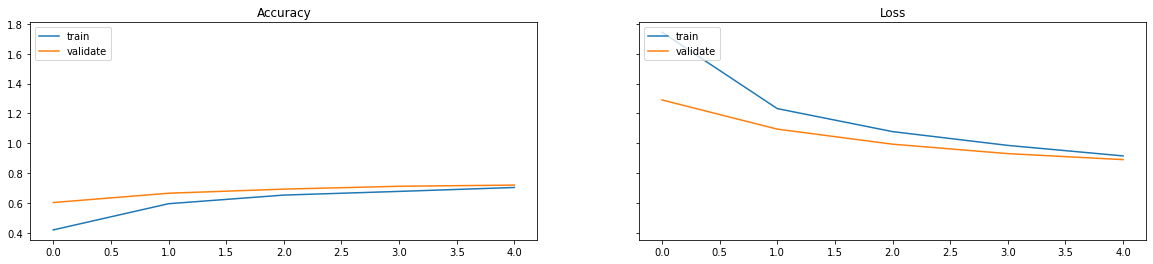

In [44]:
history_V3_red = model_V3_red.fit(
    train_generator_red, 
    epochs = n_epochs, 
    validation_data = val_generator_red
)

diagnostic_plots(history_V3_red)

### Results and Conclusion

We have now successfully trained both our homemade, basic CNN model as well as the InceptionV3 model on our data on two datasets - one reduced sample in the original proportions (26 classes in total), and one reduced sample with standardized numbers of occurrences in each class (12 classes in total). For lack of available computing resources, I've chosen to limit the number of epochs in all these tests to 5, but as is apparent in the final accuracy and loss measures for the validation data, considerably more epochs would be necessary to achieve a reliable accuracy. 

In our initial passes at training, it's interesting to note that our basic CNN architecture, while performing poorly overall (a bit over 40% accuracy across both datasets), did avoid overfitting behavior - presumably somewhat due to the very low number of training epochs used. An interesting point of note here is that in this initial pass, the base model seemed to more reliably classify the original sample data - with 26 classes occurring proportional to their number in the original dataset, than the standardized data, with 12 classes divided up evenly. This is a very suprising result, but somewhat besides the point, since the initial accuracy is so poor.

Our Inception V3 trainsfer-learning model showed itself to be far superior, which can be expected given the number of model layers it contains. It's also of note that in spite of the large number of layers in this model, it actually fewer trainable parameters than the basic model (1,576,346 vs 9,050,636), providing an object lesson in an economical model architecture. Indeed, after the first training epoch the model already acheived a better accuracy (58%) than after all five epochs of the training model. Unsurprisingly, the final validation accuracy on both datasets far outperformed our basic models (again, with very little indication of overfitting behavior). And in an interesting turn of events, the Inception V3 model performed marginally better on the standardized dataset - our expected behavior. All things being equal, we can perhaps take this as in indication that our basic model's better performance on the unaltered dataset is the result of random behavior of the dataset that would perhaps be disproved with more training passes. 

In summary, this project has been an object lesson in the effectiveness of transfer learning models. At first indication, the technique of standardizing the source dataset didn't result in a notable improvement in performance, for neither our base model architecture nor for our transfer learning architecture. In an expansion of this study, we could take a closer look at hyperparameter optimization - input image size, number of training epochs, model optimizer, learning rate, etc., could all positively affect the performance of the model in question. And in spite of the variability in the sample images that we noted during the EDA phase, the addition of a data augmentation step could go a long way towards improving model performance as well. 